In [1]:
%matplotlib inline
from skimage import io, data
import cv2 #OpenCV
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib

from sklearn.datasets import make_classification
from sklearn.cluster import k_means_
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
import time
#print("Versão do OpenCV utilizada\n {}".format(cv2.__version__))

/home/enacom/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def distribuited_fuzzy_C_means(data_batch, K, GPU_names, n_max_iters):
    setup_ts = time.time()
    number_of_gpus = len(GPU_names)
    
    sizes = [len(arg) for arg in np.array_split( data_batch, len(GPU_names))]
    result_matrix = [[] for _ in GPU_names]
    
    partial_Mu_sum_list = []
    partial_Mu_X_sum_list = []
    
    initial_centers = k_means_._init_centroids(data_batch, K, init='k-means++')
    
    tf.reset_default_graph()
    with tf.name_scope('global'):
        with tf.device('/cpu:0'):
            all_data = tf.placeholder(data_batch.dtype, shape=(data_batch.shape), name='all_data')
            
            parts = tf.split(all_data, sizes, 0)

            global_centroids = tf.Variable(initial_centers)
            
    for GPU_num in range(number_of_gpus):
        GPU_name = GPU_names[GPU_num]
        
        (X_mat) = parts[GPU_num]
        (N, M) = X_mat.get_shape().as_list()
  
        with tf.name_scope('scope_' + str(GPU_num)):
            with tf.device(GPU_name) :
                ####
                # In the coments we denote :
                # => N = Number of Observations
                # => M = Number of Dimensions
                # => K = Number of Centers
                ####
                # Data for GPU GPU_num to Clusterize
                X = tf.Variable(X_mat)

                # Reshapes rep_centroids and  rep_points to format N x K x M so that 
                # the 2 matrixes have the same size
                rep_centroids = tf.reshape(tf.tile(global_centroids, [N, 1]), [N, K, M])
                rep_points = tf.reshape(tf.tile(X, [1, K]), [N, K, M])

                # Calculates sum_squares, a matrix of size N x K
                # This matrix is just(X-Y)^2
                dist_to_centers = tf.sqrt( tf.reduce_sum(tf.square(tf.subtract( rep_points, rep_centroids) ), 
                                                         reduction_indices = 2) )
                
                # Calculates cluster_membership, a matrix of size N x K
                tmp = tf.pow(dist_to_centers, -2 / (M - 1))
                cluster_membership_with_nan = tf.div( tf.transpose(tmp), tf.reduce_sum(tmp, 1))
                
                # Error treatment for when there are zeros in count_means_aux
                cluster_membership = tf.where(
                    tf.is_nan(cluster_membership_with_nan), tf.zeros_like(cluster_membership_with_nan), cluster_membership_with_nan);
                result_matrix[GPU_num] = cluster_membership
                
                MU = tf.pow(cluster_membership, M)
                
                # Calculates auxiliar matrixes 
                # Mu_X_sum of size 
                Mu_X_sum = tf.matmul(MU, X)
                Mu_sum = tf.reduce_sum(MU, 1)
                
                partial_Mu_sum_list.append( Mu_sum )
                partial_Mu_X_sum_list.append( Mu_X_sum )
                
    with tf.name_scope('global') :
        with tf.device('/cpu:0') :
            result_matrix = tf.argmax(tf.transpose(tf.concat(result_matrix, 1)), axis = 1)
            
            global_Mu_sum = tf.add_n( partial_Mu_sum_list )
            global_Mu_X_sum = tf.transpose(  tf.add_n(partial_Mu_X_sum_list) )
            
            new_centers = tf.transpose( tf.div(global_Mu_X_sum, global_Mu_sum) )
            
            update_centroid = tf.group( global_centroids.assign(new_centers) )
        
    setup_time = float( time.time() - setup_ts )
    initialization_ts = time.time()
    
    config = tf.ConfigProto( allow_soft_placement = True )
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = 'BFC'

    with tf.Session( config = config ) as sess:
        initialization_ts = time.time()
        sess.run(tf.global_variables_initializer(), feed_dict={all_data: data_batch})
        initialization_time = float( time.time() - initialization_ts ) 
    
        computation_time = 0.0
        for i in range(n_max_iters):
            aux_ts = time.time()
            [result, _] = sess.run([global_centroids, update_centroid])
            computation_time += float(time.time() - aux_ts)
            
            cluster_idx = sess.run(result_matrix, feed_dict={all_data: data_batch})
    
    end_resut = {   'end_center'          : result             ,
                    'cluster_idx'         : cluster_idx        ,
                    'init_center'         : initial_centers    ,
                    'setup_time'          : setup_time         ,
                    'initialization_time' : initialization_time,
                    'computation_time'    : computation_time   ,
                    'n_iter'              : i+1
                }
    return end_resut

def distribuited_k_means(data_batch, K, GPU_names, n_max_iters):
    setup_ts = time.time()
    number_of_gpus = len(GPU_names)

    sizes = [len(arg) for arg in np.array_split( data_batch, len(GPU_names))]
    result_matrix = [[] for _ in GPU_names]
    
    partial_directions = []
    partial_values = []
    partial_results = []
    
    initial_centers = k_means_._init_centroids(data_batch, K, init='k-means++')
    
    tf.reset_default_graph()
    with tf.name_scope('global'):
        with tf.device('/cpu:0'):
            all_data = tf.placeholder(data_batch.dtype, shape=(data_batch.shape), name='all_data')
            parts = tf.split(all_data, sizes, 0)

            global_centroids = tf.Variable(initial_centers)
            
    for GPU_num in range(len(GPU_names)):
        GPU_name = GPU_names[GPU_num]
            
        (X_mat) = parts[GPU_num]
        (N, M) = X_mat.get_shape().as_list()
        
        with tf.name_scope('scope_' + str(GPU_num)):
            with tf.device(GPU_name) :
                ####
                # In the coments we denote :
                # => N = Number of Observations
                # => M = Number of Dimensions
                # => K = Number of Centers
                ####

                # Data for GPU GPU_num to Clusterize
                X = tf.Variable(X_mat)

                # Reshapes rep_centroids and rep_points to format N x K x M so that 
                # the 2 matrixes have the same size
                rep_centroids = tf.reshape(tf.tile(global_centroids, [N, 1]), [N, K, M])
                rep_points = tf.reshape(tf.tile(X, [1, K]), [N, K, M])

                # Calculates sum_squares, a matrix of size N x K
                # This matrix is not sqrt((X-Y)^2), it is just(X-Y)^2
                # Since we need just the argmin(sqrt((X-Y)^2)) wich is equal to 
                # argmin((X-Y)^2), it would be a waste of computation
                sum_squares = tf.reduce_sum(tf.square(tf.subtract(rep_points, rep_centroids)), axis = 2)

                # Use argmin to select the lowest-distance point
                # This gets a matrix of size N x 1
                best_centroids = tf.argmin(sum_squares, axis = 1)
                result_matrix[GPU_num] = sum_squares
                
                means = []
                for c in range(K):
                    aux_points = tf.gather(X, tf.reshape(tf.where(tf.equal(best_centroids, c)), [1,-1]))
                    means.append(tf.reduce_mean(aux_points, axis=[1]))

                new_centroids = tf.concat(means, 0)
                    
            with tf.device('/cpu:0'):
                y_count = tf.cast(
                    tf.bincount(tf.to_int32(best_centroids), maxlength = K, minlength = K), dtype = tf.float64)
                
                partial_mu =  tf.multiply( tf.transpose(new_centroids), y_count )

                partial_directions.append( y_count )
                partial_values.append( partial_mu )
                
    with tf.name_scope('global') :
        with tf.device('/cpu:0') :
            result_matrix = tf.argmin(tf.concat(result_matrix, 0), axis = 1)
            
            sum_direction = tf.add_n( partial_directions )
            sum_mu = tf.add_n( partial_values )

            rep_sum_direction = tf.reshape(tf.tile(sum_direction, [M]), [M, K])
            new_centers = tf.transpose( tf.div(sum_mu, rep_sum_direction) )

            update_centroid = tf.group( global_centroids.assign(new_centers) )
        
    setup_time = float( time.time() - setup_ts )

    config = tf.ConfigProto( allow_soft_placement = True )
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = 'BFC'

    with tf.Session( config = config ) as sess:
        initialization_ts = time.time()
        sess.run(tf.global_variables_initializer(), feed_dict={all_data: data_batch})
        initialization_time = float( time.time() - initialization_ts ) 
    
        computation_time = 0.0
        for i in range(n_max_iters):
            aux_ts = time.time()
            [result, centroids, _] = sess.run([global_centroids, best_centroids, update_centroid])
            computation_time += float(time.time() - aux_ts)
            
            cluster_idx = sess.run(result_matrix, feed_dict={all_data: data_batch})

    end_resut = {   'end_center'          : result             ,
                    'cluster_idx'         : cluster_idx        ,
                    'centroids'           : centroids          ,
                    'init_center'         : initial_centers    ,
                    'setup_time'          : setup_time         ,
                    'initialization_time' : initialization_time,
                    'computation_time'    : computation_time   ,
                    'n_iter'              : i+1
                }

    return end_resut

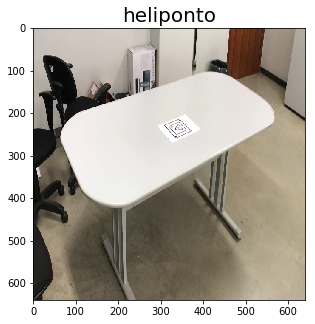

In [3]:
camera = cv2.imread('../Img_Teste_Gustavo/img_vid01_0.tif', cv2.IMREAD_COLOR)
camera_rgb = cv2.cvtColor(camera, cv2.COLOR_BGR2RGB)
camera_rgb1 = camera_rgb
plt.figure(1,figsize=(5,5))
plt.title('heliponto', size=20)
plt.imshow(camera_rgb)
plt.show()

In [4]:
camera_rgb = camera_rgb.reshape((-1,3))

In [5]:
# A imagem em tres dimensoes R-G-B
print(type(camera_rgb))
print(camera_rgb.shape)

camera_rgb = camera_rgb.astype(np.float64)
GPU_names = get_available_gpus()
print(GPU_names)

<class 'numpy.ndarray'>
(409600, 3)
['/device:GPU:0']


In [6]:
K = 2

results = distribuited_fuzzy_C_means(camera_rgb, K, GPU_names, 20)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(camera_rgb.astype(np.float32), K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [7]:
print(results['end_center'])
print(center)

[[ 211.61787506  205.26593249  196.20432444]
 [  91.59111489   82.81636151   68.17906317]]
[[ 202.50834656  194.98013306  182.91323853]
 [  87.82028198   78.92079163   64.96960449]]


In [8]:
print(results['cluster_idx'].shape)

(409600,)


In [9]:
results = distribuited_k_means(camera_rgb, K, GPU_names, 20)

In [10]:
print(results['cluster_idx'])

[1 1 1 ..., 1 1 1]


In [11]:
print(results['end_center'])
print(center)

[[  88.28355244   79.35577901   65.35167108]
 [ 202.78030078  195.27714969  183.23701455]]
[[ 202.50834656  194.98013306  182.91323853]
 [  87.82028198   78.92079163   64.96960449]]


# Testando com as imagens do video - Heliponto

In [12]:
images = glob.glob('../Img_Teste_Gustavo/img_vid01_*.tif')

for file in range(len(images))[:10]:
    img = mpimg.imread('../Img_Teste_Gustavo/img_vid01_%d.tif' % (file))
    img = img.reshape((-1,3))
    img = img.astype(np.float64)
    GPU_names = get_available_gpus()
    K = 3
    
    results = distribuited_k_means(img, K, GPU_names, 20)
    
    if np.isnan(results['end_center']).any():
        print(np.isnan(results['end_center']).any())

Centroides do frame 0


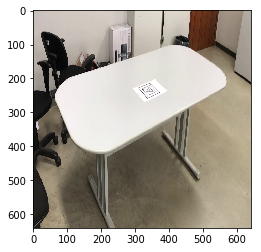

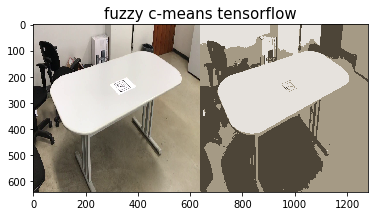

[[ 230.45782575  226.58974922  221.83325697]
 [  77.72495069   69.61074272   56.59085194]
 [ 165.32153188  154.06468883  133.36574937]]
Tempo no frame 0 
0.29248523712158203



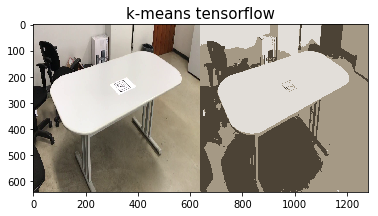

[[ 165.02862356  153.86709782  133.5585427 ]
 [  76.04970284   67.64458708   54.94145899]
 [ 226.81338295  222.31377706  217.25554023]]
Tempo no frame 0 
0.2149674892425537

Tempo k-means generico no frame 0 
1.8777379989624023


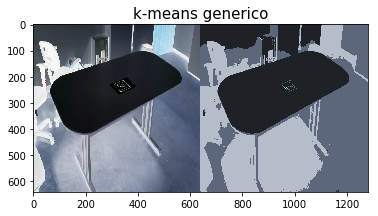

Centroides do frame 1


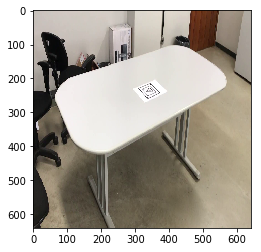

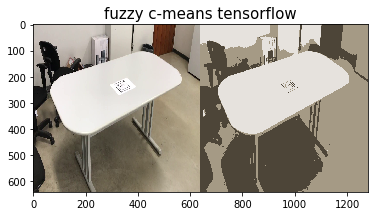

[[ 230.32451502  226.56787605  221.76122884]
 [  77.71031932   69.60892354   56.64850947]
 [ 165.311968    154.02297077  133.38718801]]
Tempo no frame 1 
0.27581787109375



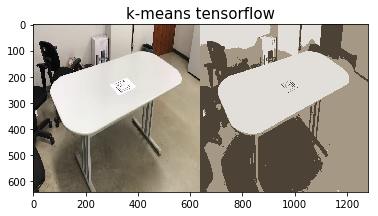

[[ 165.02687798  153.83505081  133.61610404]
 [  76.04939626   67.65639102   54.99030944]
 [ 226.69618414  222.29048343  217.19316883]]
Tempo no frame 1 
0.22724580764770508

Tempo k-means generico no frame 1 
2.400749444961548


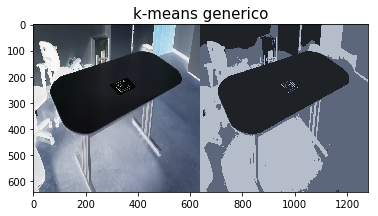

Centroides do frame 2


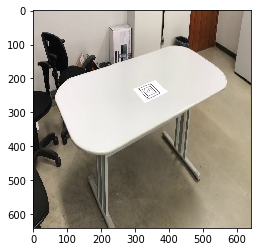

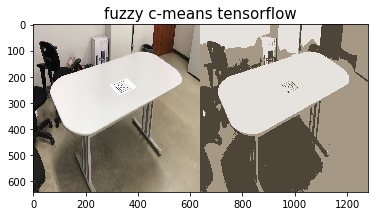

[[ 165.27824749  153.97425415  133.38805232]
 [  77.72545078   69.59844404   56.66808278]
 [ 230.234966    226.50976357  221.68225257]]
Tempo no frame 2 
0.27569580078125



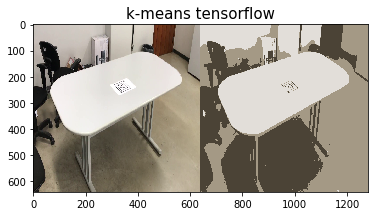

[[ 226.5432147   222.1275082   217.01568846]
 [ 164.78573871  153.57468365  133.40491764]
 [  75.99644859   67.57768337   54.93833465]]
Tempo no frame 2 
0.22525763511657715

Tempo k-means generico no frame 2 
2.005631685256958


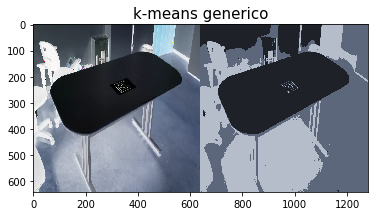

Centroides do frame 3


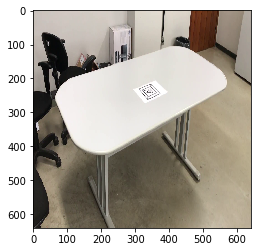

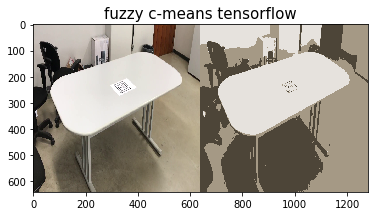

[[ 165.0368963   153.73618793  133.16437485]
 [  77.64979022   69.48418313   56.62674157]
 [ 230.12623453  226.45880204  221.59963781]]
Tempo no frame 3 
0.2773137092590332



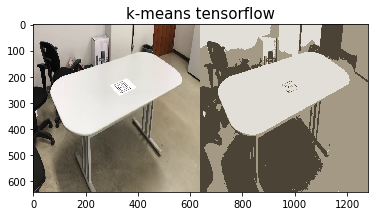

[[ 226.46073856  222.07755503  216.93790796]
 [  75.97036999   67.51943162   54.92639104]
 [ 164.55402058  153.34656986  133.22639166]]
Tempo no frame 3 
0.22117018699645996

Tempo k-means generico no frame 3 
2.0256316661834717


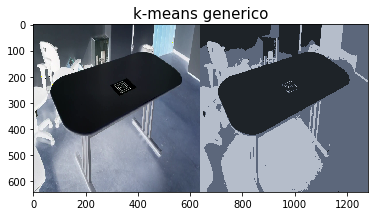

Centroides do frame 4


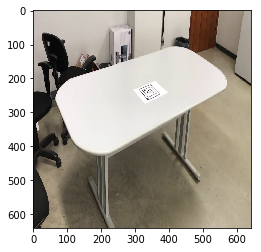

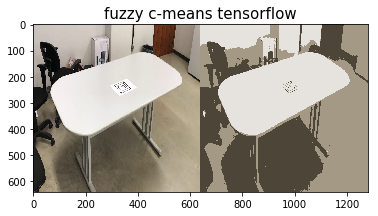

[[ 230.1068569   226.41527252  221.57929694]
 [  77.46750832   69.24266785   56.45262691]
 [ 164.95712668  153.67362962  133.11699915]]
Tempo no frame 4 
0.27632665634155273



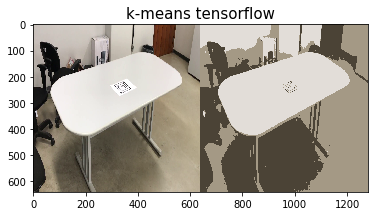

[[ 164.49044362  153.27517062  133.16514682]
 [ 226.3548127   221.96657908  216.82316846]
 [  75.86428603   67.36394818   54.8233985 ]]
Tempo no frame 4 
0.22432827949523926

Tempo k-means generico no frame 4 
1.8029110431671143


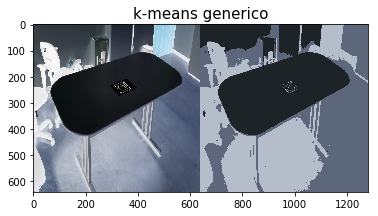

Centroides do frame 5


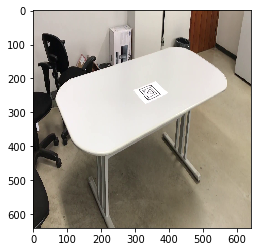

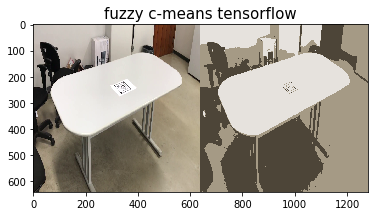

[[  77.50489878   69.24239689   56.48764455]
 [ 230.13311605  226.4402003   221.60228769]
 [ 165.42666995  154.08218097  133.64687725]]
Tempo no frame 5 
0.27649998664855957



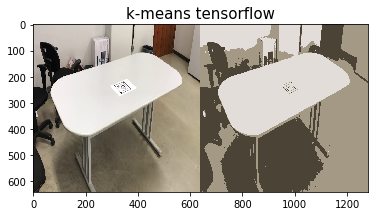

[[ 164.93875753  153.65985001  133.6581166 ]
 [  75.8423814    67.29993828   54.80239257]
 [ 226.36651158  221.98507128  216.86269912]]
Tempo no frame 5 
0.21737194061279297

Tempo k-means generico no frame 5 
1.8574459552764893


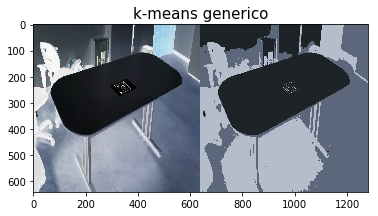

Centroides do frame 6


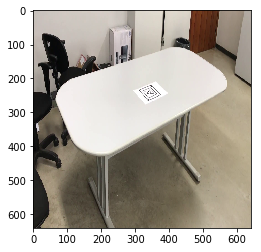

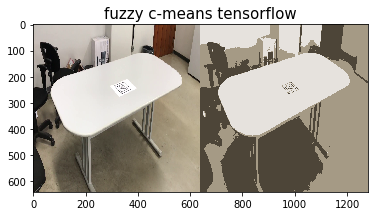

[[ 230.1229567   226.46382485  221.61222426]
 [ 165.45488276  154.10475721  133.71696417]
 [  77.4234404    69.16720203   56.42128828]]
Tempo no frame 6 
0.2788407802581787



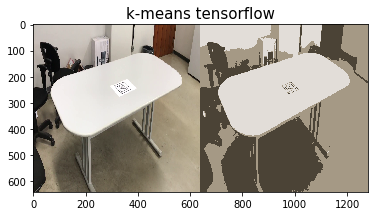

[[  75.84548219   67.32096975   54.82377107]
 [ 226.29771226  221.96734134  216.83032249]
 [ 165.00968223  153.72919145  133.75074892]]
Tempo no frame 6 
0.22148466110229492

Tempo k-means generico no frame 6 
1.817319393157959


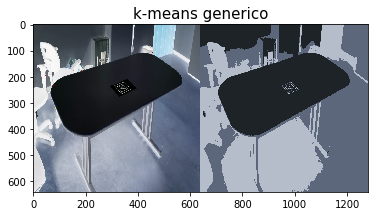

Centroides do frame 7


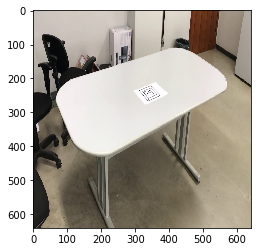

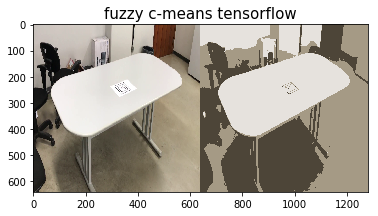

[[ 165.53288837  154.18737055  133.80449764]
 [  77.57057698   69.24253387   56.55215668]
 [ 230.09913289  226.39620535  221.51413493]]
Tempo no frame 7 
0.27927279472351074



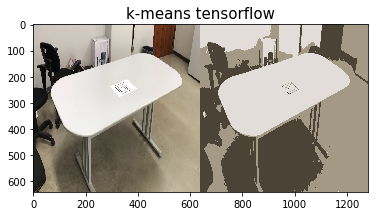

[[  75.92634843   67.33185554   54.89542522]
 [ 226.30845945  221.88119407  216.7027516 ]
 [ 164.89174853  153.62140415  133.67365504]]
Tempo no frame 7 
0.2199082374572754

Tempo k-means generico no frame 7 
1.8733303546905518


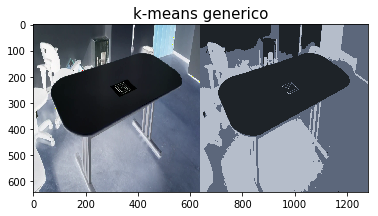

Centroides do frame 8


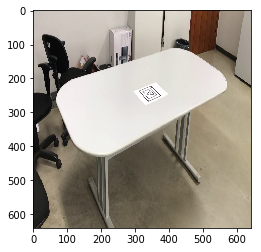

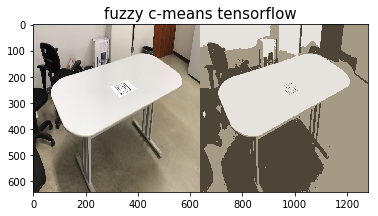

[[ 230.0085571   226.41403871  221.42241263]
 [  77.53185971   69.15519516   56.48011253]
 [ 165.41948754  154.1151575   133.67531636]]
Tempo no frame 8 
0.27729129791259766



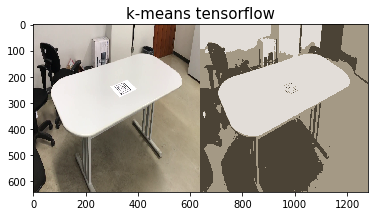

[[ 164.71553222  153.4844895   133.48490224]
 [ 226.17484568  221.83892187  216.54616439]
 [  75.92649507   67.2916992    54.85167887]]
Tempo no frame 8 
0.21710562705993652

Tempo k-means generico no frame 8 
1.771010398864746


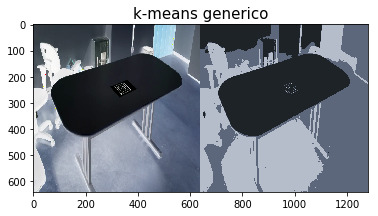

Centroides do frame 9


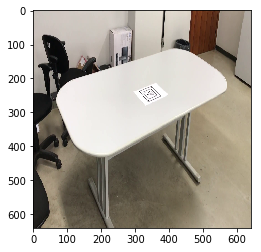

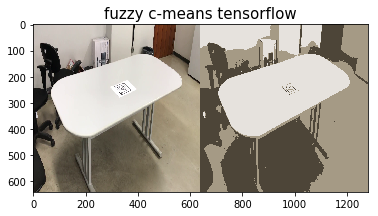

[[  77.47407373   69.07485495   56.41236189]
 [ 165.49254716  154.18806645  133.7768374 ]
 [ 230.02433487  226.33841377  221.36054033]]
Tempo no frame 9 
0.29909300804138184



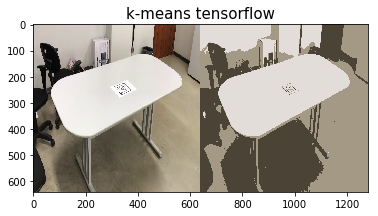

[[ 164.79543462  153.56924492  133.6102261 ]
 [  75.86252268   67.20659213   54.78681427]
 [ 226.22082736  221.80127965  216.51945578]]
Tempo no frame 9 
0.21705937385559082

Tempo k-means generico no frame 9 
1.936539649963379


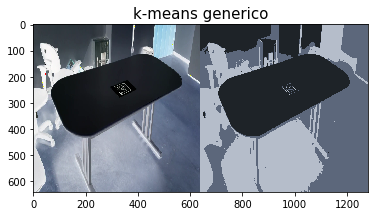

In [14]:
for fname in range(len(images))[:10]:
    print('Centroides do frame %d' % (fname))
    img = mpimg.imread('../Img_Teste_Gustavo/img_vid01_%d.tif' % (fname))
    plt.imshow(img)
    plt.show()
    img1=img.copy()
    img = img.reshape((-1,3))
    img = img.astype(np.float64)
    GPU_names = get_available_gpus()
    K = 3
    
    ### fuzzy c-means tensorflow
    results = distribuited_fuzzy_C_means(img, K, GPU_names, 20)

    center = np.uint8(results['end_center'])
    res = center[results['cluster_idx'].flatten()]
    res = res.reshape((img1.shape[0],img1.shape[1],3))
    res2 = img1.reshape((img1.shape[0],img1.shape[1],3))
    plt.figure(1)
    plt.title('fuzzy c-means tensorflow', size=15)
    plt.imshow(np.hstack([res2, res]))
    plt.show()
    
    print(results['end_center'])
    print('Tempo no frame %d ' % (fname))
    print(results['computation_time'])
    print('')
    
    ### k-means tensorflow
    results = distribuited_k_means(img, K, GPU_names, 20)

    center = np.uint8(results['end_center'])
    res = center[results['cluster_idx'].flatten()]
    res = res.reshape((img1.shape[0],img1.shape[1],3))
    res2 = img1.reshape((img1.shape[0],img1.shape[1],3))
    plt.figure(1)
    plt.title('k-means tensorflow', size=15)
    plt.imshow(np.hstack([res2, res]))
    plt.show()
    
    print(results['end_center'])
    print('Tempo no frame %d ' % (fname))
    print(results['computation_time'])
    print('')
    
    ### com k-means do opencv - comparacao
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    img2 = img1.reshape((img1.shape[0] * img1.shape[1], 3))
    img2 = img2.astype(np.float32)
    start_kmeans = time.time()
    ret,label,center=cv2.kmeans(img2,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    end = time.time()
    tempo=(end - start_kmeans)
    print('Tempo k-means generico no frame %d ' % (fname))
    print(tempo)
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img1.shape[0],img1.shape[1],3))
    res2 = img2.reshape((img1.shape[0],img1.shape[1],3))
    plt.figure(1)
    plt.title('k-means generico', size=15)
    plt.imshow(np.hstack([res2, res]))
    plt.show()